# Requirements

In [27]:
from collections import Counter
import datetime
import os
import pprint
import re
import time
from urllib import request as urllib_request

from bs4 import BeautifulSoup
# import lcp.reuse as reuse
# from Bio import Entrez
# from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
# from pybliometrics.scopus import AbstractRetrieval
# This will need an API key from: https://dev.elsevier.com/apikey/manage
import pybliometrics.scopus as pbs

# Define folders

In [2]:
SEARCH_RESULT_FOLDER = 'search_results'

if not os.path.exists(SEARCH_RESULT_FOLDER):
    os.makedirs(SEARCH_RESULT_FOLDER)

# Options to search Google Scholar

Packages found online:
- https://github.com/ckreibich/scholar.py
- https://github.com/venthur/gscholar
- https://github.com/adeel/google-scholar-scraper
- http://code.activestate.com/recipes/523047-search-google-scholar/
- https://github.com/erdiaker/torrequest
- https://github.com/NikolaiT/GoogleScraper
- https://stackoverflow.com/questions/8049520/web-scraping-javascript-page-with-python
- https://scholar.google.com/scholar/help.html
- https://superuser.com/questions/565722/how-to-config-tor-to-use-a-http-socks-proxy


# Manually get the number of citations from Google Scholar
## Methods:
### 1. Go to: https://scholar.google.com/
### 2. Type a query to get a specific MIMIC DB, i.e., "`mimic-iv`" for MIMIC-IV
### 3. Find the original paper (usually the first result, or top cited one)
### 4. Click on "`Cited by ###`" underneath the brief abstract
### 5. On the left side, click "`Custom range...`"
### 6. In both boxes, type the year you want to query, i.e., "`2023 - 2023`" to return results for only 2023, click "`Search`"
### 7. At the top, under the search bar is the number of citations that year (note, the "`About ### results`" is the exact number of results until around 1000 or so when it rounds to the nearest 20 I think due to the massive pagination request but still close enough at those numbers)

In [3]:
google_scholar_mimic_pubs = {
    # 10.1109/CIC.1996.542622
    'mimic-i': {
        '1997' :   2,
        '1998' :   1,
        '1999' :   2,
        '2000' :   4,
        '2001' :   4,
        '2002' :   4,
        '2003' :   3,
        '2004' :   7,
        '2005' :   5,
        '2006' :  10,
        '2007' :  12,
        '2008' :   3,
        '2009' :   9,
        '2010' :  10,
        '2011' :  12,
        '2012' :   7,
        '2013' :   9,
        '2014' :   7,
        '2015' :  13,
        '2016' :  18,
        '2017' :  25,
        '2018' :  14,
        '2019' :  17,
        '2020' :  30,
        '2021' :  29,
        '2022' :  23,
        '2023' :  19,
        '2024' :   0
    },
    # 10.1109/CIC.2002.1166854
    'mimic-ii': {
        '1997' :    0,
        '1998' :    0,
        '1999' :    0,
        '2000' :    0,
        '2001' :    0,
        '2002' :    0,
        '2003' :    0,
        '2004' :    0,
        '2005' :    0,
        '2006' :    0,
        '2007' :    0,
        '2008' :    0,
        '2009' :    0,
        '2010' :    0,
        '2011' :   11,
        '2012' :   37,
        '2013' :   53,
        '2014' :   81,
        '2015' :  126,
        '2016' :  175,
        '2017' :  116,
        '2018' :  122,
        '2019' :  115,
        '2020' :  118,
        '2021' :  101,
        '2022' :  112,
        '2023' :   91,
        '2024' :    0
    },
    # 10.1038/sdata.2016.35
    'mimic-iii': {
        '1997' :    0,
        '1998' :    0,
        '1999' :    0,
        '2000' :    0,
        '2001' :    0,
        '2002' :    0,
        '2003' :    0,
        '2004' :    0,
        '2005' :    0,
        '2006' :    0,
        '2007' :    0,
        '2008' :    0,
        '2009' :    0,
        '2010' :    0,
        '2011' :    0,
        '2012' :    0,
        '2013' :    0,
        '2014' :    1,
        '2014' :    0,
        '2015' :    0,
        '2016' :   24,
        '2017' :  147,
        '2018' :  428,
        '2019' :  650,
        '2020' :  960,
        '2021' : 1260,
        '2022' : 1440,
        '2023' : 1510,
        '2024' :  770
    },
    # 10.1038/s41597-022-01899-x
    'mimic-iv': {
        '1997' :   0,
        '1998' :   0,
        '1999' :   0,
        '2000' :   0,
        '2001' :   0,
        '2002' :   0,
        '2003' :   0,
        '2004' :   0,
        '2005' :   0,
        '2006' :   0,
        '2007' :   0,
        '2008' :   0,
        '2009' :   0,
        '2010' :   0,
        '2011' :   0,
        '2012' :   0,
        '2013' :   0,
        '2014' :   0,
        '2014' :   0,
        '2015' :   0,
        '2016' :   0,
        '2017' :   0,
        '2018' :   0,
        '2019' :   0,
        '2020' :   0,
        '2021' :   0,
        '2022' :   1,
        '2023' : 165,
        '2024' : 316
    },
    # 10.1038/s41597-019-0322-0
    'mimic-cxr': {
        '1997' :   0,
        '1998' :   0,
        '1999' :   0,
        '2000' :   0,
        '2001' :   0,
        '2002' :   0,
        '2003' :   0,
        '2004' :   0,
        '2005' :   0,
        '2006' :   0,
        '2007' :   0,
        '2008' :   0,
        '2009' :   0,
        '2010' :   0,
        '2011' :   0,
        '2012' :   0,
        '2013' :   0,
        '2014' :   0,
        '2014' :   0,
        '2015' :   0,
        '2016' :   0,
        '2017' :   0,
        '2018' :   0,
        '2019' :   0,
        '2020' :  24,
        '2021' :  92,
        '2022' : 181,
        '2023' : 330,
        '2024' :  22
    }
}

closed_datasets = {
    # 10.1371/journal.pmed.1001779
    'UK Biobank': {
        '2015':   18,
        '2016':   95,
        '2017':  232,
        '2018':  468,
        '2019':  697,
        '2020':  891,
        '2021': 1260,
        '2022': 1650,
        '2023': 2010,
        '2024':  183
    },
    # #
    # 'CheXpert': {
    #     '2017':   1,
    #     '2018':   3,
    #     '2019':  64,
    #     '2020': 239,
    #     '2021': 449,
    #     '2022': 599,
    #     '2023': 573,
    #     '2024':  12
    # },
    # 10.1038/s41586-020-2521-4
    'OpenSAFELY': {
        '2019':   1,
        '2020': 194,
        '2021': 257,
        '2022': 124,
        '2023':  70,
        '2024':   6
    },
    # 10.1056/NEJMsr1809937
    'All of Us': {
        '2018':   1,
        '2019':  13,
        '2020':  92,
        '2021': 175,
        '2022': 226,
        '2023': 332,
        '2024':  23
    },
    # (scopus)
    # 'All of Us': {
    #     '2018':   1,
    #     '2019':   7,
    #     '2020':  80,
    #     '2021': 128,
    #     '2022': 296,
    #     '2023': 261,
    #     '2024':  48
    # }
}

other_datasets = {
    # 10.1038/sdata.2018.178
    'eICU-CRD': {
        '2018':   4,
        '2019':  45,
        '2020': 136,
        '2021': 194,
        '2022': 263,
        '2023': 323,
        '2024':  51
    },
    # # (scopus)
    # 'eICU-CRD': {
    #     '2019':  23,
    #     '2020':  77,
    #     '2021': 130,
    #     '2022': 168,
    #     '2023': 215,
    #     '2024':  27
    # },
    # # 10.13026/nkwc-js72 (PN)
    # 'HiRID': {
    #     '2021':  3,
    #     '2022':  6,
    #     '2023': 15,
    #     '2024':  2
    # },
    # # 10.1038/s41591-020-0789-4 (SR)
    # 'HiRID': {
    #     '2021':  3,
    #     '2022':  6,
    #     '2023': 15,
    #     '2024':  2
    # },
    # # 10.1097/CCM.0000000000004916
    # # (scopus)
    # 'AmsterdamUMCdb': {
    #     '2021':  7,
    #     '2022': 22,
    #     '2023': 40,
    #     '2024':  4
    # }
    # # 
    # 'Dutch Data Warehouse': {
    #     '2021':  2,
    #     '2022': 14,
    #     '2023': 12,
    #     '2024':  1
    # }
}

# Define the funding

In [4]:
total_funding = {
    # 5R01EB017205
    # MIMIC-I: 10.1109/CIC.1996.542622
    # MIMIC-II: 10.1109/CIC.2002.1166854
    # MIMIC-III: 10.1038/sdata.2016.35
    # MIMIC-IV: 10.1038/s41597-022-01899-x
    # MIMIC-CXR: 10.1038/s41597-019-0322-0
    # NIH Reporter: Critical Care Informatics
    # Year | NIBIB  | NIGMS  | OD
    # 2014 | 458841 | 200000 | 0
    # 2015 | 430704 | 200000 | 0
    # 2016 | 433117 | 200000 | 0
    # 2017 | 415565 | 200000 | 0
    # 2018 | 385045 | 0      | 0
    # 2019 | 377810 | 0      | 0
    # 2020 | 0      | 0      | 97102
    # 2021 | 399755 | 0      | 0
    # 2022 | 0      | 0      | 0
    # 2023 | 397481 | 0      | 0
    'All MIMIC': 458841 + 200000 + 0     + \
                 430704 + 200000 + 0     + \
                 433117 + 200000 + 0     + \
                 415565 + 200000 + 0     + \
                 385045 + 0      + 0     + \
                 377810 + 0      + 0     + \
                 0      + 0      + 97102 + \
                 399755 + 0      + 0     + \
                 0      + 0      + 0     + \
                 397481 + 0      + 0,
    # https://www.ukbiobank.ac.uk/media/wgsfd0qg/uk-biobank-funding-details-summary.pdf
    # Total = 413.8 million GBP = 525,546,276.20 USD (June 9, 2024 conversion rate)
    'UK Biobank': 525546276.20,
    # Welcome Trust (222097), MRC (MR/W016729/1), MRC (MR/V015757/1)?, MC_PC_20051, MC_PC_20058,
    # MC_PC_20059, NIHR135559, COV-LT-0009, COV-LT2-0073
    'OpenSAFELY': 2874941.71 + 774508.54 + 0 + 6055626.76 + 19188252.00 + 11454881.49 + 403228.32 + 12109587.17 + 854028.70,
    # doi: 10.1056/NEJMsr1809937
    'All of Us': 2.16e9,
    'eICU-CRD': 0,
    # https://doi.org/10.1038/s41591-020-0789-4
    # Funding for this work was provided by the Swiss National Science Foundation (grant no. 176005 to G.R. and T.M.M. and SNSF Starting Grant no. 155913 to K.B.). G.R., S.L.H. and K.B. received core funding from ETH Zürich.
    # 756,819 CHF + 1,420,850 CHF
    'HiRID': 756819 + 1420850,
    'PIC': np.nan,
    'AmsterdamUMCdb': np.nan,
}
print(total_funding)

{'All MIMIC': 4195420, 'UK Biobank': 525546276.2, 'OpenSAFELY': 53715054.690000005, 'All of Us': 2160000000.0, 'eICU-CRD': 0, 'HiRID': 2177669, 'PIC': nan, 'AmsterdamUMCdb': nan}


# Plot the growth of each DB adjusted from the start time

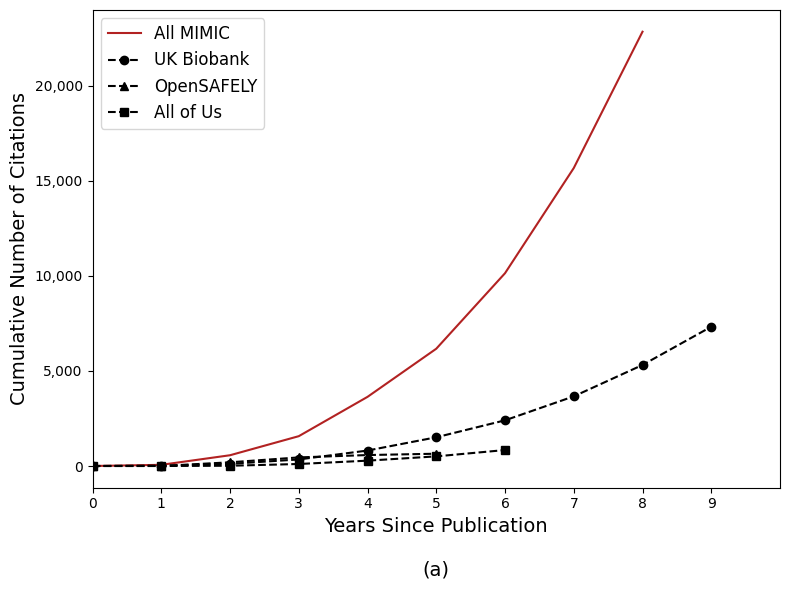

{'All MIMIC': {'x_data': range(0, 28),
               'y_data': array([    0,    62,   566,  1568,  3635,  6165, 10134, 15662, 22829,
       23697, 24693, 25802, 27026, 28350, 28426, 28514, 28609, 28713,
       28824, 28948, 29090, 29257, 29438, 29636, 29864, 30121, 30401,
       30700], dtype=int32)},
 'All of Us': {'x_data': range(0, 7), 'y_data': [0, 1, 14, 106, 281, 507, 839]},
 'OpenSAFELY': {'x_data': range(0, 6), 'y_data': [0, 1, 195, 452, 576, 646]},
 'UK Biobank': {'x_data': range(0, 10),
                'y_data': [0, 18, 113, 345, 813, 1510, 2401, 3661, 5311, 7321]},
 'mimic-cxr': {'x_data': range(0, 5),
               'y_data': array([  0,  24, 116, 297, 627], dtype=int32)},
 'mimic-i': {'x_data': range(0, 28),
             'y_data': array([  0,   2,   3,   5,   9,  13,  17,  20,  27,  32,  42,  54,  57,
        66,  76,  88,  95, 104, 111, 124, 142, 167, 181, 198, 228, 257,
       280, 299], dtype=int32)},
 'mimic-ii': {'x_data': range(0, 14),
              'y_data': array(

In [52]:
max_year = 2023
max_mimic = 9
ALL_MIMIC = True
current_db = google_scholar_mimic_pubs.copy()
fig_title = 'All MIMIC'
xlim_max = 10

years = [int(y) for y in current_db[list(current_db.keys())[0]].keys()]
db_order = ['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
][:len(db_order)]

plt.figure(figsize=(8,6))

all_data_output = {}
if ALL_MIMIC:
    all_x_data = []
    all_y_data = []
for i,db in enumerate(db_order):
    for y,v in current_db[db].items():
        if v != 0:
            start_year = int(y)
            break
    y_data = [0, *[v for y,v in current_db[db].items() if ((int(y) >= start_year) and (int(y) <= max_year))]]
    y_data = np.cumsum(y_data)
    x_data = range(len(y_data))
    if ALL_MIMIC:
        all_y_data.append(y_data)
    else:
        plt.plot(x_data, y_data, color=colors[i], label=db.upper())
    all_data_output[db] = {
        'x_data': x_data,
        'y_data': y_data
    }
if ALL_MIMIC:
    max_len = max([len(a) for a in all_y_data])
    all_y_data = np.cumsum(np.sum([np.pad(a, (0, max_len-len(a)), 'constant') for a in all_y_data], axis=0))
    all_x_data = range(len(all_y_data))
    plt.plot(all_x_data[:max_mimic], all_y_data[:max_mimic], color=colors[i], label=fig_title)
    all_data_output['All MIMIC'] = {
        'x_data': all_x_data,
        'y_data': all_y_data
    }

closed_markers = ['o', '^', 's']
for i,closed_dataset in enumerate(closed_datasets.items()):
    start_year = int(list(closed_dataset[1].keys())[0])
    y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) <= max_year))]
    y_data = [0, *np.cumsum(y_data)]
    x_data = range(len(y_data))
    plt.plot(x_data[:xlim_max+1], y_data[:xlim_max+1], color='k', linestyle='--', marker=closed_markers[i], label=closed_dataset[0])
    all_data_output[closed_dataset[0]] = {
        'x_data': x_data,
        'y_data': y_data
    }

plt.xlabel('Years Since Publication\n\n(a)', fontsize=14)
plt.ylabel('Cumulative Number of Citations', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(0,len(labels))
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper left', fontsize=12)
# legend.get_frame().set_alpha(1)
# plt.grid(zorder=-1, axis='y')
plt.xlim([0,xlim_max])
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticks(range(xlim_max))
plt.tight_layout()
ms = 'MIMIC-together' if ALL_MIMIC else 'MIMIC-apart'
plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, f'growth-line___{ms}_all-time_all-closed.png'))
plt.show()

pprint.pprint(all_data_output)

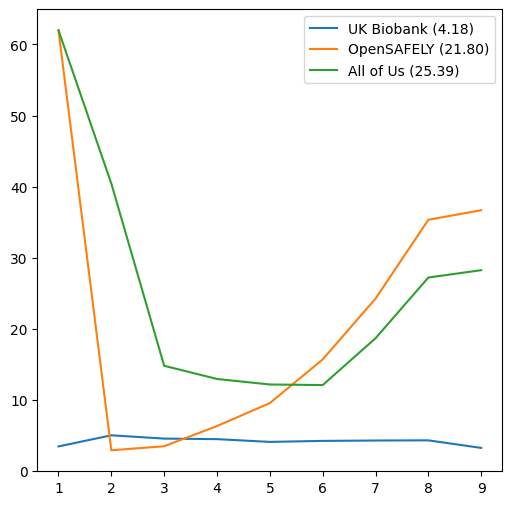

In [56]:
x_min = 1
x_max = 10
mimiciii_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['All MIMIC']['x_data'],
    all_data_output['All MIMIC']['y_data']
)
ukbiobank_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['UK Biobank']['x_data'],
    all_data_output['UK Biobank']['y_data']
)
opensafely_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['OpenSAFELY']['x_data'],
    all_data_output['OpenSAFELY']['y_data']
)
allofus_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['All of Us']['x_data'],
    all_data_output['All of Us']['y_data']
)

plt.figure(figsize=(6,6))
plt.plot(np.arange(x_min, x_max, 1), mimiciii_data/ukbiobank_data, label=f'UK Biobank ({np.mean(mimiciii_data/ukbiobank_data):.2f})')
plt.plot(np.arange(x_min, x_max, 1), mimiciii_data/opensafely_data, label=f'OpenSAFELY ({np.mean(mimiciii_data/opensafely_data):.2f})')
plt.plot(np.arange(x_min, x_max, 1), mimiciii_data/allofus_data, label=f'All of Us ({np.mean(mimiciii_data/allofus_data):.2f})')
plt.legend()
# plt.ylim([0,500])
ax = plt.gca()
plt.show()

# Plot the growth of each DB adjusted from the start time and normalized by total funding received

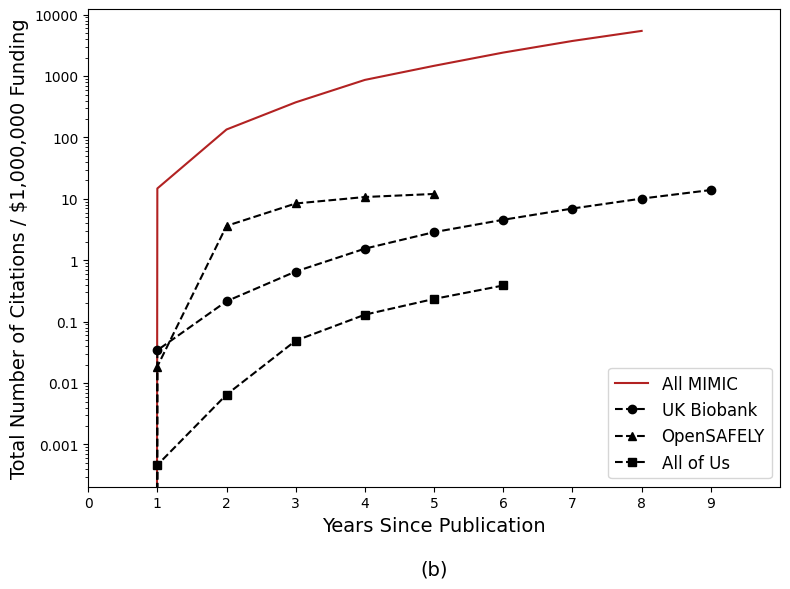

{'All MIMIC': {'x_data': range(0, 28),
               'y_data': array([   0.        ,   14.77801984,  134.90901984,  373.74088887,
        866.42100195, 1469.45955351, 2415.49117848, 3733.11849588,
       5441.40991843, 5648.3021962 , 5885.70393429, 6150.03980531,
       6441.78651959, 6757.36874973, 6775.48374179, 6796.45899576,
       6819.10273584, 6843.89167235, 6870.34909497, 6899.90513465,
       6933.75156719, 6973.55687869, 7016.69916242, 7063.89348385,
       7118.23846003, 7179.49573583, 7246.23518027, 7317.50337273])},
 'All of Us': {'x_data': range(0, 7),
               'y_data': array([0.        , 0.00046296, 0.00648148, 0.04907407, 0.13009259,
       0.23472222, 0.38842593])},
 'OpenSAFELY': {'x_data': range(0, 6),
                'y_data': array([ 0.        ,  0.01861675,  3.63026718,  8.41477315, 10.72325074,
       12.02642357])},
 'UK Biobank': {'x_data': range(0, 10),
                'y_data': array([ 0.        ,  0.03425008,  0.21501437,  0.65645979,  1.54696177,
  

In [71]:
colors = [
    'cornflowerblue',
    'lightsteelblue',
    'dimgray',
    'lightcoral',
    'firebrick'
]
max_year = 2024
max_mimic = 9
ALL_MIMIC = True

years = [int(y) for y in google_scholar_mimic_pubs[list(google_scholar_mimic_pubs.keys())[0]].keys()]
db_order = ['mimic-i','mimic-ii','mimic-iii','mimic-iv','mimic-cxr']

plt.figure(figsize=(8,6))

all_data_output = {}
if ALL_MIMIC:
    all_x_data = []
    all_y_data = []
for i,db in enumerate(db_order):
    for y,v in google_scholar_mimic_pubs[db].items():
        if v != 0:
            start_year = int(y)
            break
    y_data = [v for y,v in google_scholar_mimic_pubs[db].items() if ((int(y) >= start_year) and (int(y) < max_year))]
    y_data = np.array([0, *np.cumsum(y_data)])
    x_data = range(len(y_data))
    if ALL_MIMIC:
        all_y_data.append(y_data)
    else:
        plt.plot(x_data, y_data, color=colors[i], label=db.upper())
    all_data_output[db] = {
        'x_data': x_data,
        'y_data': y_data
    }
if ALL_MIMIC:
    max_len = max([len(a) for a in all_y_data])
    all_x_data = range(max_len)
    all_y_data = np.cumsum(np.sum([np.pad(a, (0, max_len-len(a)), 'constant') for a in all_y_data], axis=0))
    all_y_data = np.array(all_y_data/(total_funding['All MIMIC']/1000000))
    total_funds = float(total_funding['All MIMIC'])
    plt.plot(all_x_data[:max_mimic], all_y_data[:max_mimic], color=colors[i], label=f'All MIMIC')#: ${total_funds:,.2f}')
    all_data_output['All MIMIC'] = {
        'x_data': all_x_data,
        'y_data': all_y_data
    }

closed_markers = ['o', '^', 's']
for i,closed_dataset in enumerate(closed_datasets.items()):
    start_year = int(list(closed_dataset[1].keys())[0])
    y_data = [v for y,v in closed_dataset[1].items() if ((int(y) >= start_year) and (int(y) < max_year))]
    y_data = np.array([0, *np.cumsum(y_data)])
    x_data = range(len(y_data))
    try:
        total_funds = float(total_funding[closed_dataset[0]])
        plt.plot(x_data, y_data/(total_funding[closed_dataset[0]]/1000000), color='k', linestyle='--', marker=closed_markers[i], label=closed_dataset[0]) #f'{closed_dataset[0]}: ${total_funds:,.2f}')
    except KeyError:
        continue
    all_data_output[closed_dataset[0]] = {
        'x_data': x_data,
        'y_data': y_data/(total_funding[closed_dataset[0]]/1000000)
    }

plt.xlabel('Years Since Publication\n\n(b)', fontsize=14)
plt.ylabel('Total Number of Citations / $1,000,000 Funding', fontsize=14)
handles, labels = plt.gca().get_legend_handles_labels()
order = np.arange(0,len(labels))
legend = plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=12)
# legend.get_frame().set_alpha(1)
# plt.grid(zorder=-1, axis='y')
plt.xlim([0,10])
plt.yscale('log')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
ax.set_xticks(range(0,10))
plt.tight_layout()
ms = 'MIMIC-together' if ALL_MIMIC else 'MIMIC-apart'
plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, f'growth-line-fadj___{ms}_all-time_all-closed_log.png'))
plt.show()

pprint.pprint(all_data_output)

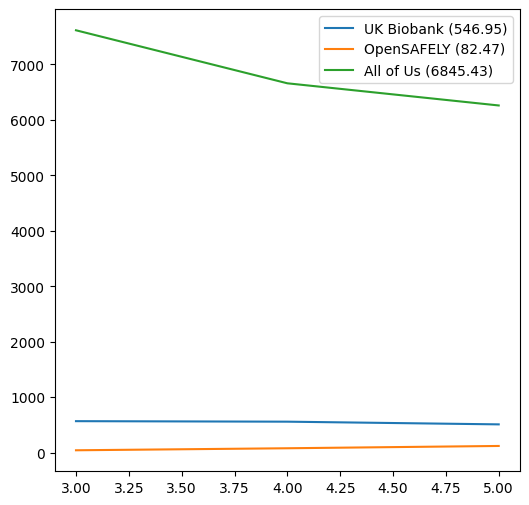

In [73]:
x_min = 3
x_max = 6
mimiciii_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['All MIMIC']['x_data'],
    all_data_output['All MIMIC']['y_data']
)
ukbiobank_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['UK Biobank']['x_data'],
    all_data_output['UK Biobank']['y_data']
)
opensafely_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['OpenSAFELY']['x_data'],
    all_data_output['OpenSAFELY']['y_data']
)
allofus_data = np.interp(
    np.arange(x_min, x_max, 1),
    all_data_output['All of Us']['x_data'],
    all_data_output['All of Us']['y_data']
)

plt.figure(figsize=(6,6))
plt.plot(np.arange(x_min, x_max, 1), mimiciii_data/ukbiobank_data, label=f'UK Biobank ({np.mean(mimiciii_data/ukbiobank_data):.2f})')
plt.plot(np.arange(x_min, x_max, 1), mimiciii_data/opensafely_data, label=f'OpenSAFELY ({np.mean(mimiciii_data/opensafely_data):.2f})')
plt.plot(np.arange(x_min, x_max, 1), mimiciii_data/allofus_data, label=f'All of Us ({np.mean(mimiciii_data/allofus_data):.2f})')
plt.legend()
# plt.ylim([0,500])
ax = plt.gca()
plt.show()

# Perform the scraping from Google Scholar

In [ ]:
DB_NAME = 'eICU-CRD'

# User-Agent spoofing
# NOTE: this list may get outdated and need updating ... consider ScrapeOps API key?
user_agent_list = [
    'Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.2; Trident/6.0; Touch)',
    'Mozilla/5.0 (iPhone; CPU iPhone OS 14_4_2 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/14.0.3 Mobile/15E148 Safari/604.1',
    'Mozilla/5.0 (iPhone; CPU iPhone OS 5_1 like Mac OS X) AppleWebKit/534.46 (KHTML, like Gecko) Version/5.1 Mobile/9B179 Safari/7534.48.3',
    'Mozilla/5.0 (iPad; U; CPU iPhone OS 3_2 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Version/4.0.4 Mobile/7B314 Safari/531.21.10',
    'Mozilla/5.0 (Linux; U; Android 4.0.4; en-gb; GT-I9300 Build/IMM76D) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_3; en-us; Silk/1.1.0-80) AppleWebKit/533.16 (KHTML, like Gecko) Version/5.0 Safari/533.16 Silk-Accelerated=true',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.102 Safari/537.36 Edge/18.18363',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36 Edg/87.0.664.75',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.82 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36',
]
# TODO: figure out proxies?
# proxies = {
#   'http': 'http://10.10.1.10:3128',
#   'https': 'http://10.10.1.10:1080',
# }

# Skip the -1 years since already complete
# NOTE: if the numbers aren't changing then you may have to wait until
#       Google Scholar isn't mad anymore
# NOTE: get `article_id` from Google Scholar link after clicking on desired citation
# TODO: automate this
# TODO: can only go up to 1000, but most of those >1000 should be ~1 at least for these studies
# start_idxs = {
#     2019: 0,
#     2020: 0,
#     2021: 0,
#     2022: 0,
#     2023: 0
# }
if DB_NAME == 'UK-Biobank':
    # start at 2015
    article_id = 2590122798384494947
elif DB_NAME == 'OpenSAFELY':
    # start at 2020
    article_id = 17080000567303433977
elif DB_NAME == 'MIMIC-I':
    # start at 1997
    article_id = 5955822449530493366
elif DB_NAME == 'MIMIC-II':
    # start at 2003
    article_id = 7755589053673476801
elif DB_NAME == 'MIMIC-III':
    # start at 2016
    article_id = 4115250243685522
elif DB_NAME == 'MIMIC-IV':
    # start at 2020
    article_id = 7925337910889488074
elif DB_NAME == 'MIMIC-CXR':
    # start at 2020
    article_id = 680754441348545603
elif DB_NAME == 'All-of-Us':
    # start at 2019
    article_id = 15378313725393442879
elif DB_NAME == 'PIC':
    # start at 2019
    article_id = 1274953236010921452
elif DB_NAME == 'eICU-CRD':
    # start at 2018
    article_id = 11878669525996073977
    start_idxs = {
        2018: -1,
        2019: -1,
        2020: -1,
        2021: -1,
        2022: -1,
        2023: 110
    }
elif DB_NAME == 'AmsterdamUMCdb':
    # start at 2021
    article_id = 69090949308303245
    start_idxs = {
        2021: 0,
        2022: 0,
        2023: 0
    }
query_years = list(start_idxs.keys())
results_dict = {y:[] for y in query_years}

total_queries = 0
# Be nice to the bot police
max_queries = 25
for query_year in query_years:
    print(query_year)
    start_idx = start_idxs[query_year]
    if start_idx == -1:
        continue
    # NOTE: Have to go year by year since google scholar does not render more than 100 pages = 1000 citations at a time
    # TODO: Ideally, this would chose dates between every 1000 but that is hard
    # First page
    link_dir = f'https://scholar.google.com/scholar?start=0&hl=en&as_ylo={query_year}&as_yhi={query_year}&sciodt=0,5&cites={article_id}&scipsc='
    temp_user_agent = user_agent_list[-1]
    req = urllib_request.Request(link_dir, headers={'User-Agent': temp_user_agent})
    html_page = urllib_request.urlopen(req).read()
    soup = BeautifulSoup(html_page, 'html.parser')
    # Example: "About 1,250 results (0.09 sec)"
    try:
        # This is safer
        total_citations = int(re.compile('About (.*) results? \\(').findall(str(soup))[0].replace(',',''))
    except IndexError:
        # I don't trust this one as much
        total_citations = int(re.compile('([0-9,]*) results? \\(').findall(str(soup))[0].replace(',',''))
    all_citations = []
    total_queries += 1
    if total_queries == max_queries:
        print('Query limit reached: change `start_idxs` to the end of this execution')
        raise SystemExit(0)

    # NOTE: google scholar shows 10 at a time for now, get the desired page
    for i,temp_idx in enumerate(np.arange(start_idx,total_citations,10)):
        link_dir = f'https://scholar.google.com/scholar?start={temp_idx}&hl=en&as_ylo={query_year}&as_yhi={query_year}&sciodt=0,5&cites={article_id}&scipsc='
        req = urllib_request.Request(link_dir, headers={'User-Agent': temp_user_agent})
        html_page = urllib_request.urlopen(req).read()
        soup = BeautifulSoup(html_page, 'html.parser')
        temp_citations = [int(c) for c in re.compile('Cited by ([0-9]*)').findall(str(soup))]
        # Fill in the rest with 0s since they don't have the 'Cited by ([0-9]*)' phrase
        expected_len = len(re.compile('Related articles').findall(str(soup)))
        all_citations.extend(np.pad(temp_citations, (0,expected_len-len(temp_citations)), 'constant').tolist())
        print(f'DONE: {start_idx+len(all_citations)}/{total_citations}')
        # Avoid the bot police
        total_queries += 1
        if total_queries == max_queries:
            results_dict[query_year] = all_citations
            print('Query limit reached: change `start_idxs` to the end of this execution')
            raise SystemExit(0)
        time.sleep(10)

    results_dict[query_year] = all_citations

# Run this if the above fails mid-way through

In [ ]:
results_dict[query_year] = all_citations
results_dict

# Save the results to a CSV

In [16]:
file_name = os.path.join('citations', f'citations___{DB_NAME}.csv')
try:
    old_df = pd.read_csv(file_name, index_col=0).dropna()
except FileNotFoundError:
    with open(file_name, 'w') as f:
        f.write(',Year,Citations\n')
    old_df = pd.read_csv(file_name, index_col=0).dropna()
new_df = pd.DataFrame(data=[(k,i) for k in results_dict.keys() for i in results_dict[k]], columns=['Year','Citations'])
merged_df = pd.concat([old_df,new_df], ignore_index=True).astype(int)
pd.DataFrame(data=merged_df).to_csv(file_name)

# Visualize the results

False False False


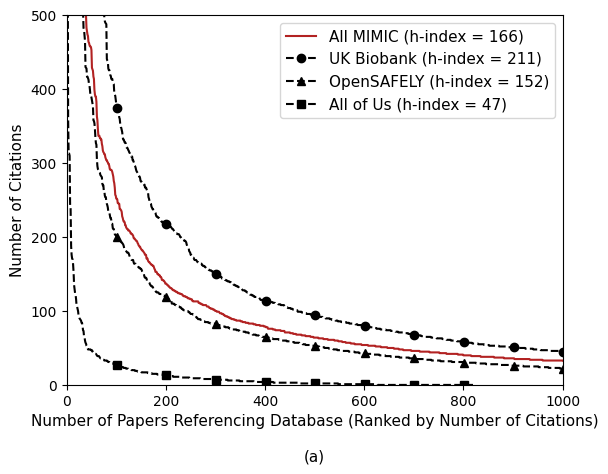

False False True


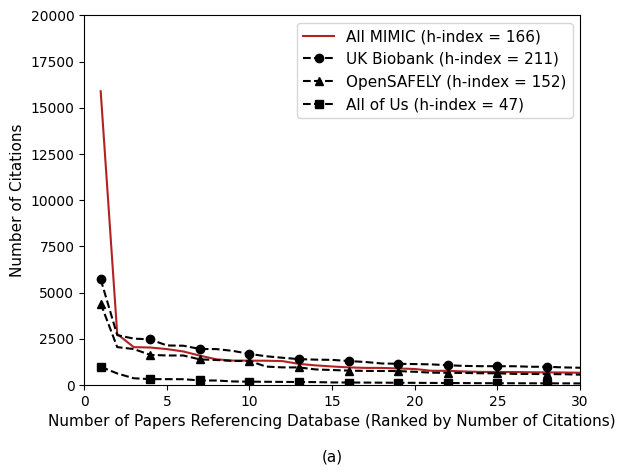

False True False


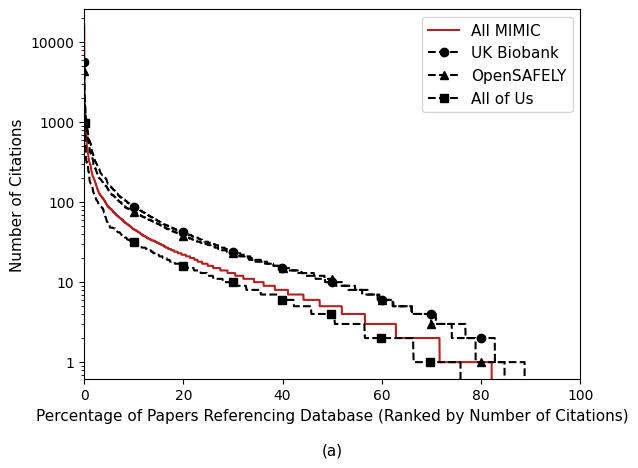

False True True


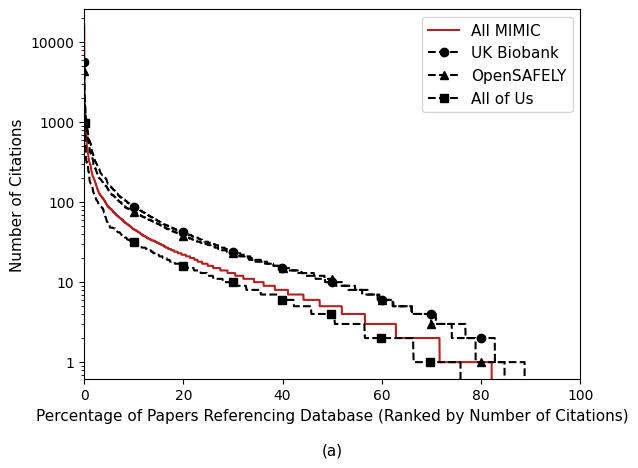

True False False


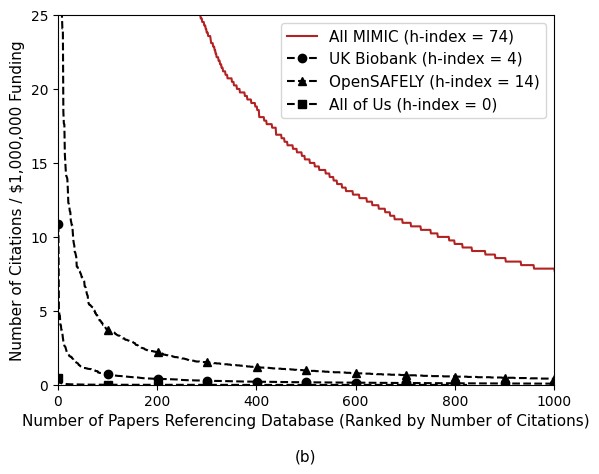

True False True


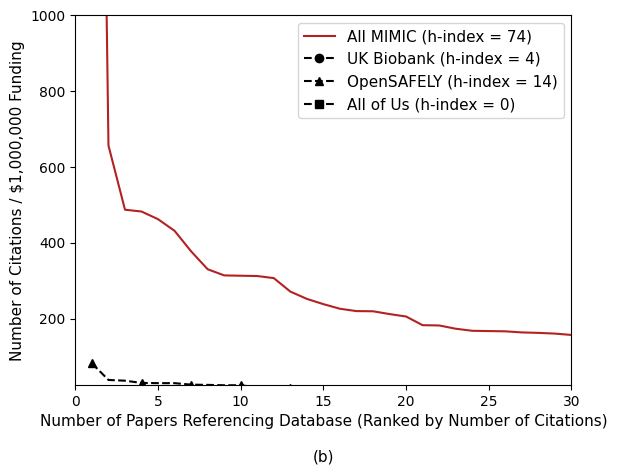

True True False


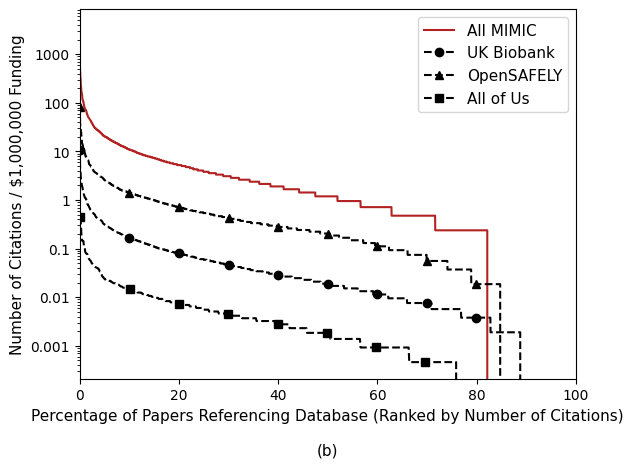

True True True


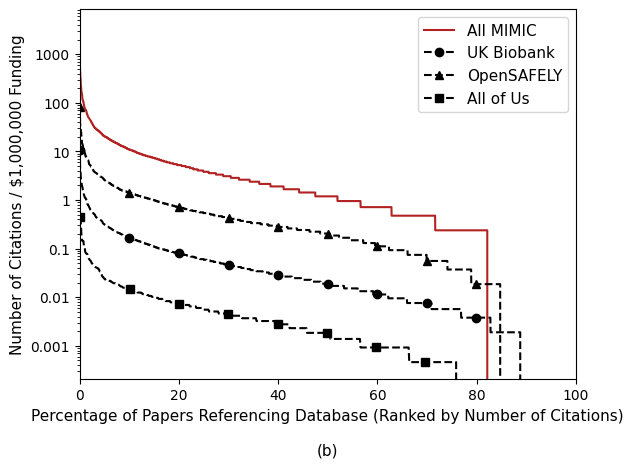

{(False, False, False): {'All MIMIC': {'x_data': array([   1,    2,    3, ..., 7043, 7044, 7045]),
                                       'y_data': array([15892,  2754,  2044, ...,     0,     0,     0], dtype=int64)},
                         'All of Us': {'x_data': array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 1

In [81]:
db_names = ['All MIMIC', 'UK Biobank', 'OpenSAFELY', 'All of Us']
all_markers = [None, 'o', '^', 's']
# Open data = '-', Closed data = '--'
linestyles = ['-', '--', '--', '--']

total_mimic_df = []
for temp_db_name in ['MIMIC-I', 'MIMIC-II', 'MIMIC-III', 'MIMIC-IV', 'MIMIC-CXR',]:
    total_mimic_df.extend(list(pd.read_csv(os.path.join('citations',f'citations___{temp_db_name}.csv'), index_col=0).to_numpy()[:,1].flatten()))

all_data_output = {}
for FUNDING_ADJUSTED in [False, True]:
    for X_PERCENT_ADJUSTED in [False, True]:
        for SHOW_Y_MAX in [False, True]:
            all_data_output[(FUNDING_ADJUSTED, X_PERCENT_ADJUSTED, SHOW_Y_MAX)] = {}
            for tbn,temp_db_name in enumerate(db_names):
                if linestyles[tbn] == '-':
                    if temp_db_name == 'All MIMIC':
                        total_df = np.array(total_mimic_df)
                    else:
                        total_df = np.array(list(pd.read_csv(os.path.join('citations',f'citations___{temp_db_name.replace(" ","-")}.csv'), index_col=0).to_numpy()[:,1].flatten()))
                    plot_color = 'firebrick'
                else:
                    total_df = np.array(list(pd.read_csv(os.path.join('citations',f'citations___{temp_db_name.replace(" ","-")}.csv'), index_col=0).to_numpy()[:,1].flatten()))
                    plot_color = 'k'

                c = np.array(sorted(total_df, reverse=True))
                h_index = 0
                for i in np.arange(0,len(total_df)):
                    if c[i] >= i:
                        h_index = i
                    else:
                        break

                c_adj = np.array(sorted(total_df, reverse=True)) / (total_funding[temp_db_name]/1000000)
                h_index_adj = 0
                for i in np.arange(0,len(total_df)):
                    if c_adj[i] >= i:
                        h_index_adj = i
                    else:
                        break

                if FUNDING_ADJUSTED:
                    total_df = total_df / (total_funding[temp_db_name]/1000000)
                if X_PERCENT_ADJUSTED:
                    plot_label = temp_db_name
                else:
                    if FUNDING_ADJUSTED:
                        plot_label = f'{temp_db_name} (h-index = {h_index_adj})'
                    else:
                        plot_label = f'{temp_db_name} (h-index = {h_index})'

                if X_PERCENT_ADJUSTED:
                    markevery = int(len(total_df)/10)
                    temp_x_data = 100*np.arange(1,len(total_df)+1)/len(total_df)
                    temp_y_data = np.array(sorted(total_df, reverse=True))
                    plt.plot(temp_x_data, temp_y_data, marker=all_markers[tbn], markevery=markevery, linestyle=linestyles[tbn], color=plot_color, label=plot_label)
                else:
                    if SHOW_Y_MAX:
                        x_max = 30
                    else:
                        x_max = 1000
                    markevery = int(x_max/10)
                    temp_x_data = np.arange(1,len(total_df)+1)
                    temp_y_data = np.array(sorted(total_df, reverse=True))
                    plt.plot(temp_x_data, temp_y_data, marker=all_markers[tbn], markevery=markevery, linestyle=linestyles[tbn], color=plot_color, label=plot_label)
                all_data_output[(FUNDING_ADJUSTED, X_PERCENT_ADJUSTED, SHOW_Y_MAX)][temp_db_name] = {
                    'x_data': temp_x_data,
                    'y_data': temp_y_data
                }

            if X_PERCENT_ADJUSTED:
                xlabel = 'Percentage of Papers Referencing Database (Ranked by Number of Citations)'
            else:
                xlabel = 'Number of Papers Referencing Database (Ranked by Number of Citations)'
            xlabel = f'{xlabel}\n\n(b)' if FUNDING_ADJUSTED else f'{xlabel}\n\n(a)'
            if FUNDING_ADJUSTED:
                ylabel = 'Number of Citations / $1,000,000 Funding'
            else:
                ylabel = 'Number of Citations'
            plt.xlabel(xlabel, fontsize=11)
            plt.ylabel(ylabel, fontsize=11)
            plt.legend(fontsize=11)
            if X_PERCENT_ADJUSTED:
                plt.xlim([0,100])
                plt.yscale('log')
                ax = plt.gca()
                ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))
            else:
                plt.xlim([0,x_max])
                if SHOW_Y_MAX:
                    if FUNDING_ADJUSTED:
                        y_min = 25
                        y_max = 1000
                    else:
                        y_min = 0
                        y_max = 20000
                else:
                    if FUNDING_ADJUSTED:
                        y_min = 0
                        y_max = 25
                    else:
                        y_min = 0
                        y_max = 500
                plt.ylim([y_min,y_max])
            print(FUNDING_ADJUSTED, X_PERCENT_ADJUSTED, SHOW_Y_MAX)
            s_funding = 'fadj' if FUNDING_ADJUSTED else ''
            s_xpercent = 'xper' if X_PERCENT_ADJUSTED else ''
            s_ymax = 'ymax' if SHOW_Y_MAX else ''
            s_title = f'h-index___{s_funding}-{s_xpercent}-{s_ymax}'
            plt.savefig(os.path.join(SEARCH_RESULT_FOLDER, s_title))
            plt.show()

pprint.pprint(all_data_output)

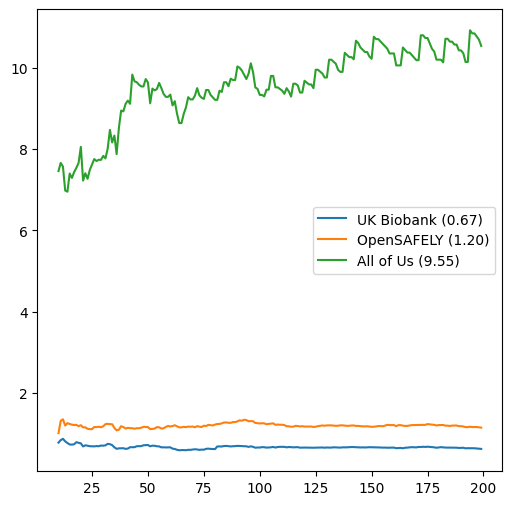

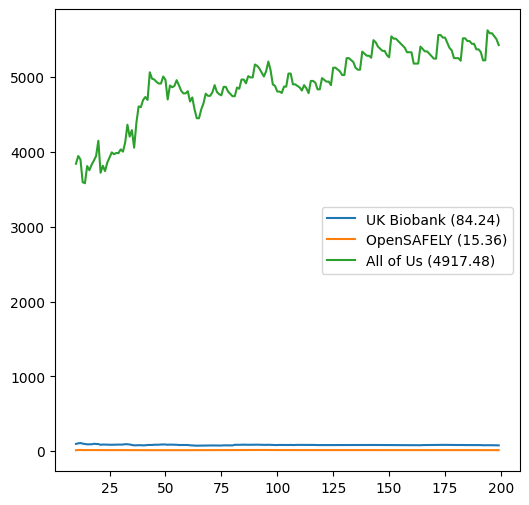

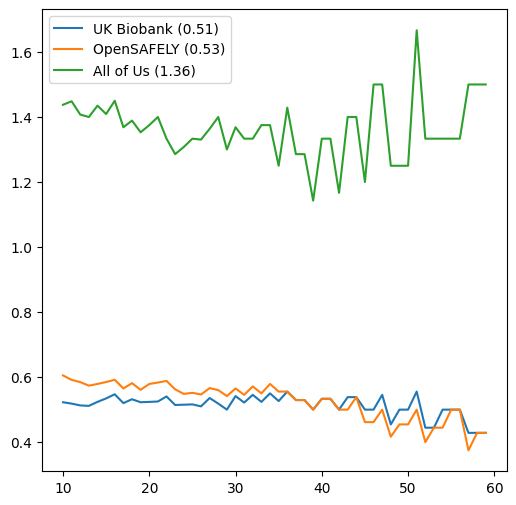

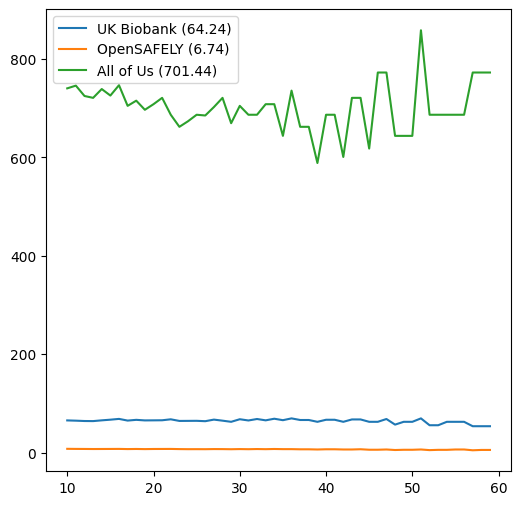

In [79]:
all_keys = [
    (False, False, False),
    (True, False, False),
    (False, True, True),
    (True, True, True)
]

for temp_key in all_keys:
    if temp_key[1]:
        x_min = 10
        x_max = 60
    else:
        x_min = 10
        x_max = 200
    mimic_data = np.interp(
        np.arange(x_min, x_max, 1),
        all_data_output[temp_key]['All MIMIC']['x_data'],
        all_data_output[temp_key]['All MIMIC']['y_data']
    )
    ukbiobank_data = np.interp(
        np.arange(x_min, x_max, 1),
        all_data_output[temp_key]['UK Biobank']['x_data'],
        all_data_output[temp_key]['UK Biobank']['y_data']
    )
    opensafely_data = np.interp(
        np.arange(x_min, x_max, 1),
        all_data_output[temp_key]['OpenSAFELY']['x_data'],
        all_data_output[temp_key]['OpenSAFELY']['y_data']
    )
    allofus_data = np.interp(
        np.arange(x_min, x_max, 1),
        all_data_output[temp_key]['All of Us']['x_data'],
        all_data_output[temp_key]['All of Us']['y_data']
    )

    plt.figure(figsize=(6,6))
    plt.plot(np.arange(x_min, x_max, 1), mimic_data/ukbiobank_data, label=f'UK Biobank ({np.mean(mimic_data/ukbiobank_data):.2f})')
    plt.plot(np.arange(x_min, x_max, 1), mimic_data/opensafely_data, label=f'OpenSAFELY ({np.mean(mimic_data/opensafely_data):.2f})')
    plt.plot(np.arange(x_min, x_max, 1), mimic_data/allofus_data, label=f'All of Us ({np.mean(mimic_data/allofus_data):.2f})')
    plt.legend()
    # plt.ylim([0,500])
    ax = plt.gca()
    plt.show()